# Data transformation

## Imports

In [28]:
import os
from typing import Tuple

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, normalize

from src.utils.const import DATA_DIR, FIGURE_DIR, NUM_BINS
from src.visualization.visualize import kdeplot

### Useful path to data

In [29]:
ROOT_DIR = os.path.join(os.getcwd(), '..')
PROCESSED_DIR = os.path.join(ROOT_DIR, DATA_DIR, 'processed')
PLOT_DIR = os.path.join(ROOT_DIR, FIGURE_DIR)

In [30]:
if not os.path.exists(PLOT_DIR):
    os.makedirs(PLOT_DIR)

## Reading final dataset

In [31]:
final = pd.read_parquet(
    os.path.join(PROCESSED_DIR, 'final.parquet')
)

### Ground truth discretization

Since we have that the rating mean stays in a continues range between [0.5-5]. We decided to discretize into 10 bins of equal length where every one has a range of 0.45.

In [32]:
final = final.assign(rating_discrete=pd.cut(final.loc[:, 'rating_mean'], bins=NUM_BINS, labels=False))

### Separate train/test/val

In order to try different strategies of normalization and standardization, we need to split the dataset into train, test and validate set. As always suggested, we use the 20% of the dataset for the test and the 10% of the training set, for the validation.

In [33]:
data = final.loc[:, final.columns != 'rating_discrete']
target = final['rating_discrete']
train_data, test_data, train_target, test_target = train_test_split(data, target, test_size=0.2, stratify=target)
train_data, val_data, train_target, val_target = train_test_split(train_data, train_target, test_size=0.1,
                                                                  stratify=train_target)

## Min-max scaling/standardization evaluation

We first define a function that allows to apply the min-max scaling transformation on the whole dataset.

In [34]:
def min_max_scaling(train_x, val_x, test_x, cols):
    train_x_scale = train_x.copy()
    val_x_scale = val_x.copy()
    test_x_scale = test_x.copy()
    scaler = MinMaxScaler()
    for features in cols:
        feature_train = train_x_scale[features].to_numpy().reshape(-1, 1)
        feature_val = val_x_scale[features].to_numpy().reshape(-1, 1)
        feature_test = test_x_scale[features].to_numpy().reshape(-1, 1)

        scaled_train = np.squeeze(scaler.fit_transform(feature_train))
        scaled_val = np.squeeze(scaler.transform(feature_val))
        scaled_test = np.squeeze(scaler.transform(feature_test))

        train_x_scale[features] = scaled_train
        val_x_scale[features] = scaled_val
        test_x_scale[features] = scaled_test

    return train_x_scale, val_x_scale, test_x_scale

As we have seen during the lectures, we have to see the distribution of each variable, in order to decide which is the most suitable method.

#### title_length

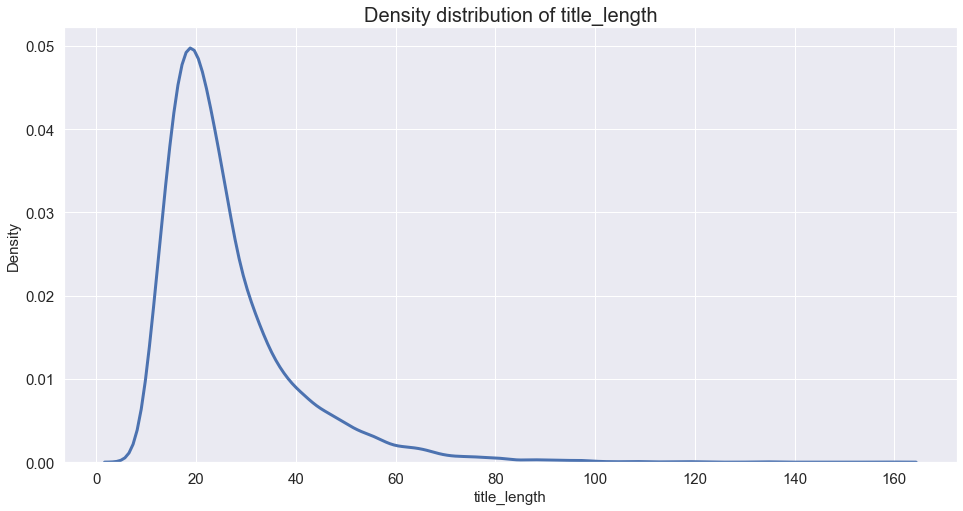

In [35]:
kdeplot(train_data['title_length'],
        title='Density distribution of title_length',
        xlabel='title_length',
        ylabel='Density', filename=os.path.join(PLOT_DIR, 'original_title_len.png'))

The distribution is not gaussian therefore we end up to apply min-max scaling in order to scale values in the range [0,1].

In [36]:
train_data_minmax, val_data_minmax, test_data_minmax = min_max_scaling(train_data, val_data, test_data,
                                                                       ['title_length'])

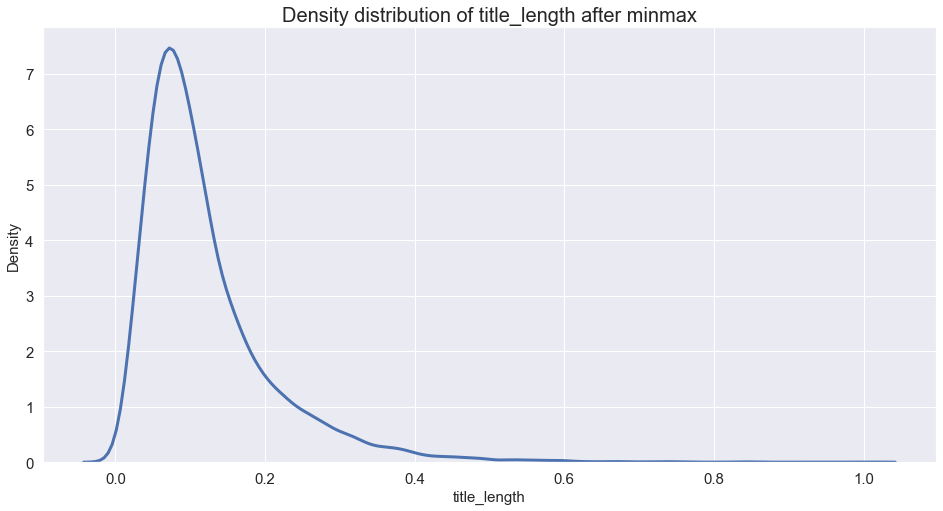

In [37]:
kdeplot(train_data_minmax['title_length'],
        title='Density distribution of title_length after minmax',
        xlabel='title_length',
        ylabel='Density', filename=os.path.join(PLOT_DIR, 'minmax_title_len.png'))

#### runtime

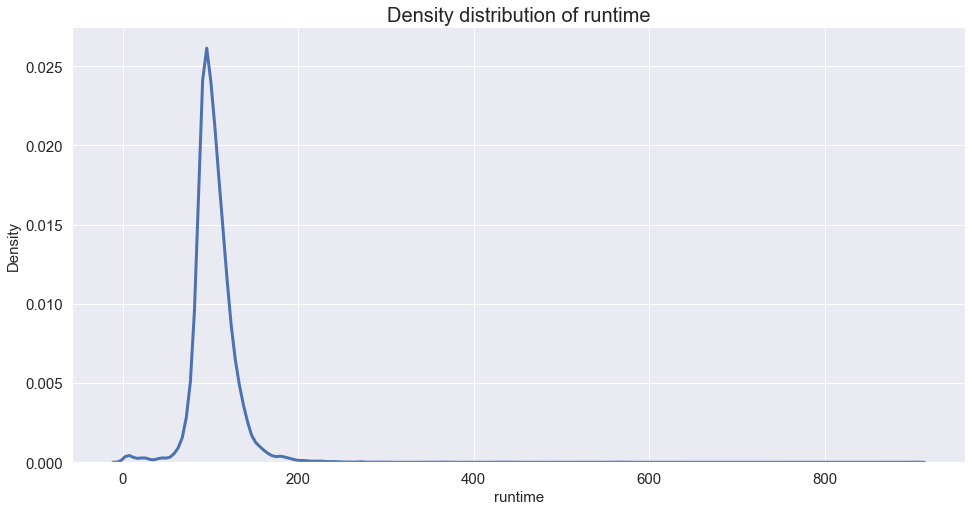

In [38]:
kdeplot(train_data['runtime'],
        title='Density distribution of runtime',
        xlabel='runtime',
        ylabel='Density', filename=os.path.join(PLOT_DIR, 'original_runtime.png'))

In [39]:
feature = ['title_length', 'runtime']

In [40]:
train_data_minmax, val_data_minmax, test_data_minmax = min_max_scaling(train_data, val_data, test_data,
                                                                       feature)

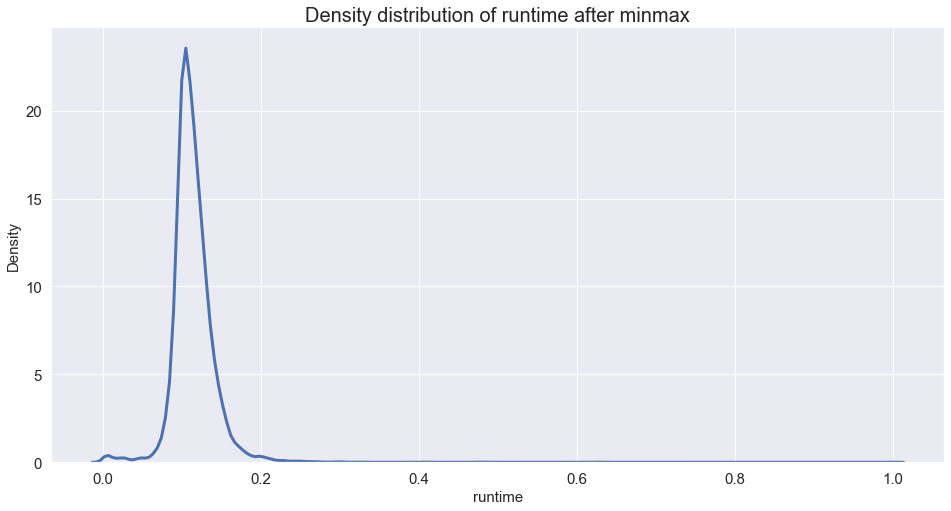

In [41]:
kdeplot(train_data_minmax['runtime'],
        title='Density distribution of runtime after minmax',
        xlabel='runtime',
        ylabel='Density', filename=os.path.join(PLOT_DIR, 'minmax_runtime.png'))

#### rating_count

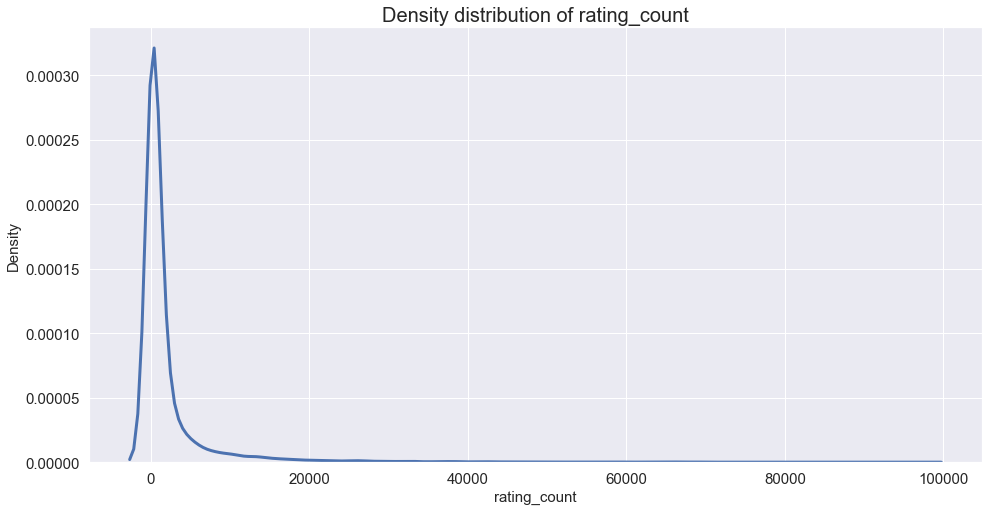

In [42]:
kdeplot(train_data['rating_count'],
        title='Density distribution of rating_count',
        xlabel='rating_count',
        ylabel='Density', filename=os.path.join(PLOT_DIR, 'original_rating_count.png'))

In [43]:
feature = ['title_length', 'runtime', 'rating_count']

In [44]:
train_data_minmax, val_data_minmax, test_data_minmax = min_max_scaling(train_data, val_data, test_data,
                                                                       feature)

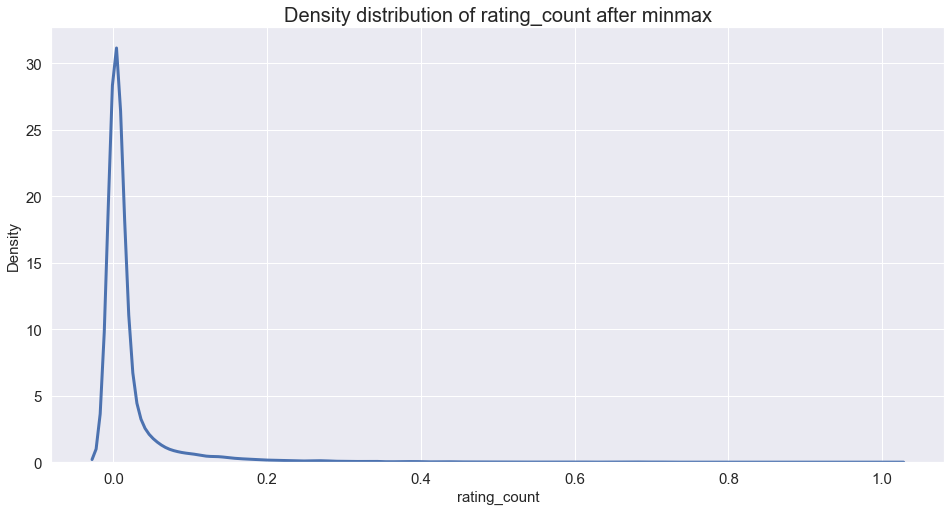

In [45]:
kdeplot(train_data_minmax['rating_count'],
        title='Density distribution of rating_count after minmax',
        xlabel='rating_count',
        ylabel='Density', filename=os.path.join(PLOT_DIR, 'minmax_rating_count.png'))

#### tag_count

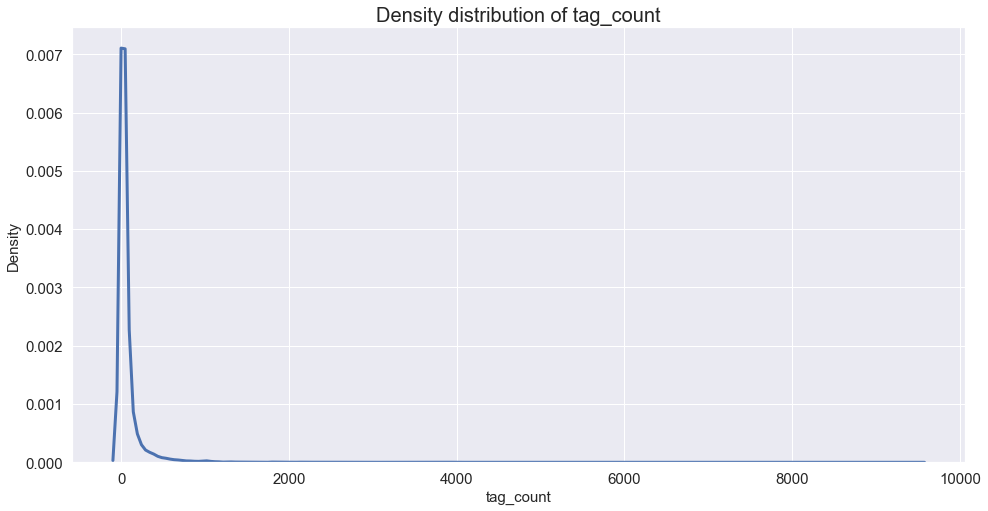

In [46]:
kdeplot(train_data['tag_count'],
        title='Density distribution of tag_count',
        xlabel='tag_count',
        ylabel='Density', filename=os.path.join(PLOT_DIR, 'original_tag_count.png'))

In [47]:
feature = ['title_length', 'runtime', 'rating_count', 'tag_count']

In [48]:
train_data_minmax, val_data_minmax, test_data_minmax = min_max_scaling(train_data, val_data, test_data,
                                                                       feature)

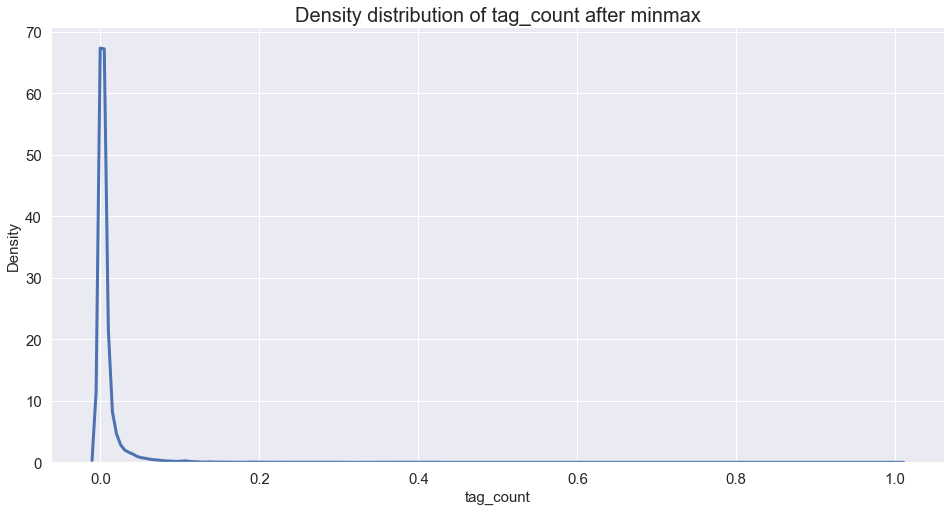

In [49]:
kdeplot(train_data_minmax['tag_count'],
        title='Density distribution of tag_count after minmax',
        xlabel='tag_count',
        ylabel='Density', filename=os.path.join(PLOT_DIR, 'minmax_tag_count.png'))

#### year

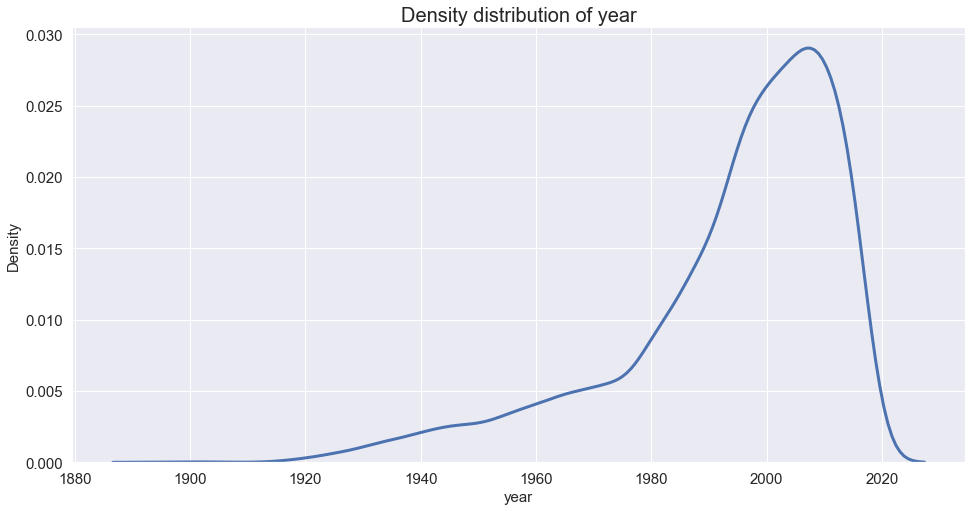

In [50]:
kdeplot(train_data['year'],
        title='Density distribution of year',
        xlabel='year',
        ylabel='Density', filename=os.path.join(PLOT_DIR, 'original_year.png'))

In [51]:
feature = ['title_length', 'runtime', 'rating_count', 'tag_count', 'year']

In [52]:
train_data_minmax, val_data_minmax, test_data_minmax = min_max_scaling(train_data, val_data, test_data,
                                                                       feature)

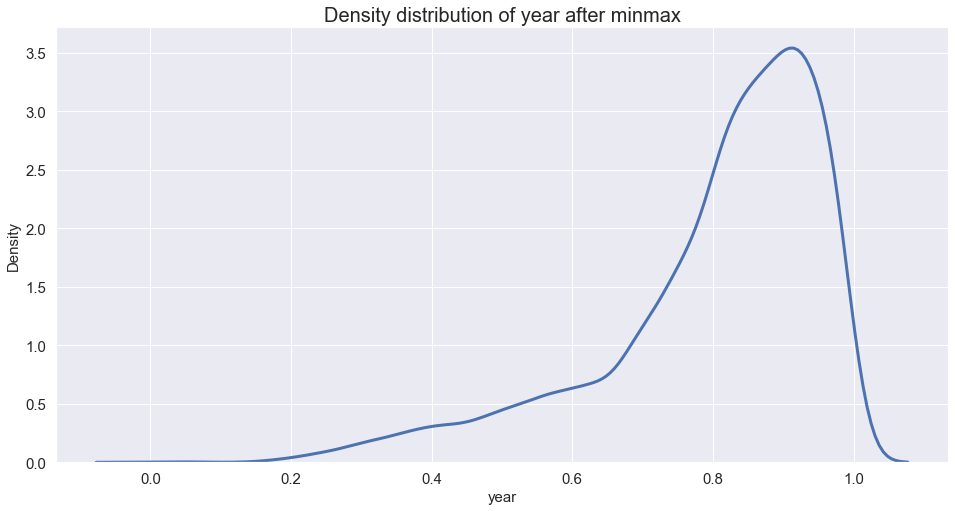

In [53]:
kdeplot(train_data_minmax['year'],
        title='Density distribution of year after minmax',
        xlabel='year',
        ylabel='Density', filename=os.path.join(PLOT_DIR, 'minmax_year.png'))

## Normalization

For the normalization, we decided to use the l2 normalization

In [56]:
def normalization(train_x, val_x, test_x, ord) -> Tuple:
    x_train_normalized = train_x.copy()
    x_val_normalized = val_x.copy()
    x_test_normalized = test_x.copy()

    x_train_normalized.iloc[:, :] = normalize(train_x, norm=ord)
    x_val_normalized.iloc[:, :] = normalize(val_x, norm=ord)
    x_test_normalized.iloc[:, :] = normalize(test_x, norm=ord)

    return x_train_normalized, x_val_normalized, x_test_normalized

In [59]:
x_train_norm, x_val_norm, x_test_norm = normalization(train_data, val_data_minmax, test_data_minmax, 'l2')